In [1]:
# import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

In [2]:
rune_data_filename = 'data/Rune_Data.csv'

rune_dataframe = pd.read_csv(rune_data_filename)
rune_dataframe.tail(20)

,timestamp,Fire_rune,Water_rune,Air_rune,Earth_rune,Mind_rune,Body_rune,Death_rune,Nature_rune,Chaos_rune,Law_rune,Cosmic_rune,Blood_rune,Soul_rune
160,1576195200000,5,4,5,4,3,4,201,223,66,166,121,302,145
161,1576281600000,5,5,5,4,3,4,202,221,66,167,118,303,145
162,1576368000000,5,5,5,5,3,4,203,219,66,166,115,302,145
163,1576454400000,5,5,5,5,4,5,204,219,66,166,112,302,144
164,1576540800000,5,5,5,5,4,5,204,218,66,166,110,303,144
165,1576627200000,5,5,5,5,4,5,204,216,67,166,113,303,144
166,1576713600000,5,5,5,5,3,5,203,216,67,166,118,302,144
167,1576800000000,5,5,5,5,3,4,203,216,67,164,121,301,140
168,1576886400000,5,5,5,4,3,5,202,216,67,158,119,302,143
169,1576972800000,5,5,5,5,3,5,203,215,66,152,113,302,145


In [3]:
def univariate_data(dataset, sequence_length):
    
    
    tscv = TimeSeriesSplit(len(dataset)-sequence_length, sequence_length)
    
    train_data = []
    train_labels = []

    for train_index, test_index in tscv.split(dataset):
        X, Y = dataset[train_index], dataset[test_index]
        train_data.append(X)
        train_labels.append(Y)

    train_data = np.stack(train_data) 
    train_labels = np.stack(train_labels).squeeze()

    return train_data, train_labels

In [4]:
target = 'Law_rune'

In [5]:
uni_data = rune_dataframe[target]
uni_data.index = rune_dataframe['timestamp']

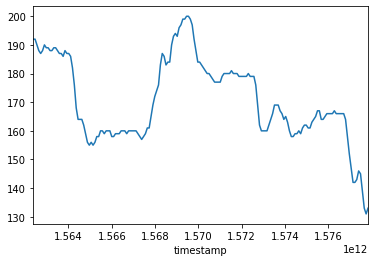

In [6]:
uni_data.plot()

In [7]:
uni_data = uni_data.values
uni_data.shape

(180,)

In [8]:
# normalize data
scaler = MinMaxScaler(feature_range=(-1,1))

uni_data = scaler.fit_transform(uni_data.reshape(-1,1))
uni_data.shape

(180, 1)

In [9]:
uni_data[:11]

array([[0.76811594],
       [0.76811594],
       [0.71014493],
       [0.65217391],
       [0.62318841],
       [0.65217391],
       [0.71014493],
       [0.68115942],
       [0.68115942],
       [0.65217391],
       [0.65217391]])

In [10]:
history = 10
x_train_uni, y_train_uni = univariate_data(uni_data, history)
y_train_uni
print(x_train_uni.shape)
print(y_train_uni.shape)

(170, 10, 1)
(170,)


In [11]:
x_train_uni = torch.Tensor(x_train_uni)
y_train_uni = torch.Tensor(y_train_uni)

# create Dataset
dataset = TensorDataset(x_train_uni, y_train_uni)
dataloader = DataLoader(dataset, shuffle=False)


# for num_iter, (seq, label) in enumerate(dataloader):
#     print(num_iter)
#     print(seq.shape)
#     print(label.shape)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
class RnnModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super().__init__()
        
        # define some parameters
        self.hidden_dim = hidden_dim

        # define layers
        # RNN layers
        self.lstm = nn.LSTM(input_size, 
                            hidden_dim)
        #FC layers
        self.fc = nn.Linear(hidden_dim, 
                            output_size)
    
    def forward(self, x):
        x = x.to(device)
        # set initial hidden and cell states
        h0 = torch.zeros(1,1,self.hidden_dim).to(device)
        c0 = torch.zeros(1,1,self.hidden_dim).to(device)
        # forward propagate 
#         print(h0.size())
#         print(c0.size())
#         print(x.size())
#         print(x.view(len(x),1,-1).size())
        out, _ = self.lstm(x.view(len(x),1,-1), (h0, c0))
        
        # decode hidden of last time step
        
        out = self.fc(out.view(len(x), -1))
        
        
        return out[-1]


In [14]:
uni_model = RnnModel(input_size=1, output_size=1, hidden_dim=100)

In [15]:
# hyperparameters
n_epochs = 200
lr = .02

# define loss and optimizer 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(uni_model.parameters(), lr=lr)

In [16]:
uni_model.to(device)

RnnModel(
  (lstm): LSTM(1, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
uni_model.train()
for epoch in range(n_epochs):
    for num_iter, (seq, label) in enumerate(dataloader):
        seq = seq.to(device)
        label = label.to(device)
        seq = seq.reshape(10,1)

        
        
        optimizer.zero_grad()
        
        
        output = uni_model(seq)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

    if epoch%10 == 0:
        print(f'Epoch: {epoch}/{n_epochs}.........')
        print(f'Loss: {loss.item()}')

Epoch: 0/200.........
Loss: 0.04473068192601204
Epoch: 10/200.........
Loss: 0.0035766279324889183
Epoch: 20/200.........
Loss: 0.0038635414093732834
Epoch: 30/200.........
Loss: 0.004974421579390764
Epoch: 40/200.........
Loss: 0.0016391337849199772
Epoch: 50/200.........
Loss: 0.002137385308742523
Epoch: 60/200.........
Loss: 0.0020582082215696573
Epoch: 70/200.........
Loss: 0.0015109400264918804
Epoch: 80/200.........
Loss: 7.782705506542698e-05
Epoch: 90/200.........
Loss: 4.903708031633869e-06
Epoch: 100/200.........
Loss: 0.00017571872740518302
Epoch: 110/200.........
Loss: 0.000257777952356264
Epoch: 120/200.........
Loss: 0.003981893416494131
Epoch: 130/200.........
Loss: 0.0003313087217975408
Epoch: 140/200.........
Loss: 0.00017605547327548265
Epoch: 150/200.........
Loss: 0.005075300112366676
Epoch: 160/200.........
Loss: 0.00043229764560237527
Epoch: 170/200.........
Loss: 0.002804525662213564
Epoch: 180/200.........
Loss: 0.0005515202647075057
Epoch: 190/200.........
Loss

In [18]:
fut_pred = 10

uni_test_inputs = uni_data[-history:].squeeze(1).tolist()
print(uni_test_inputs)

[-0.5362318840579707, -0.6811594202898554, -0.6811594202898554, -0.6521739130434785, -0.5652173913043477, -0.5942028985507246, -0.7681159420289854, -0.9420289855072461, -1.0, -0.9420289855072461]


In [19]:
uni_model.eval()

uni_test_outputs = []
for i in range(history):
    print(len(uni_test_outputs))
    seq = torch.FloatTensor(uni_test_inputs[-history:])
    with torch.no_grad():
        uni_test_outputs.append(uni_model(seq).item())
        
print(uni_test_outputs)        

0
1
2
3
4
5
6
7
8
9
[-1.0009346008300781, -1.0009346008300781, -1.0009346008300781, -1.0009346008300781, -1.0009346008300781, -1.0009346008300781, -1.0009346008300781, -1.0009346008300781, -1.0009346008300781, -1.0009346008300781]


In [20]:
x = np.arange(170,180,1) 

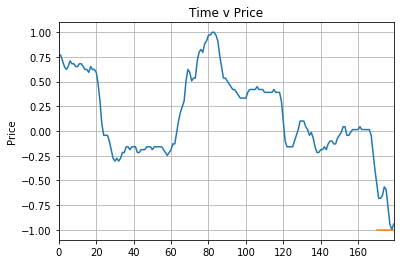

In [21]:
plt.title("Time v Price")
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(uni_data)
plt.plot(x, uni_test_outputs)
plt.show()

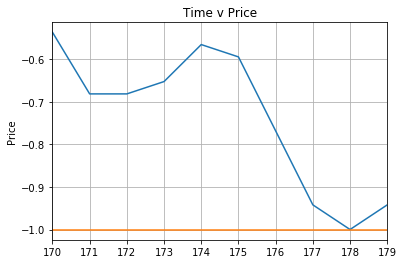

In [22]:
plt.title('Time v Price')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(x,uni_data[-history:])
plt.plot(x,uni_test_outputs)
plt.show()

Multivariate Data Time-Series Analysis

In [23]:
multi_data = rune_dataframe.iloc[:, 7:]
multi_data.index = rune_dataframe['timestamp']

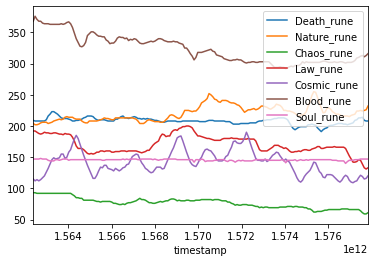

In [24]:
multi_data.plot()

In [25]:
# normalize data
scaler = MinMaxScaler((-1,1))

multi_data_scaled = scaler.fit_transform(multi_data)
multi_data_scaled.shape

(180, 7)

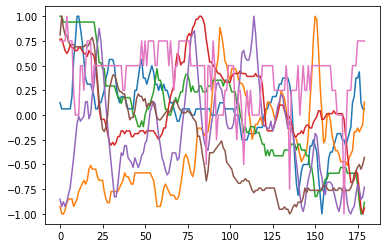

In [26]:
plt.plot(multi_data_scaled)

In [27]:
def multivariate_data(dataset, sequence_length, target):
    
    
    tscv = TimeSeriesSplit(len(dataset)-sequence_length, sequence_length)
    
    train_data = []
    train_labels = []

    for train_index, test_index in tscv.split(dataset):
        X, Y = dataset[train_index], dataset[test_index][0][target]
        train_data.append(X)
        train_labels.append(Y)

    train_data = np.stack(train_data) 
    train_labels = np.stack(train_labels).squeeze()

    return train_data, train_labels

In [28]:
history = 10
target_iloc = multi_data.columns.get_loc(target)
print(target_iloc)
x_train_multi, y_train_multi = multivariate_data(multi_data_scaled, history, target_iloc)
y_train_multi
print(x_train_multi.shape)
print(y_train_multi.shape)
print(f'target: {target}')

3
(170, 10, 7)
(170,)
target: Law_rune


In [29]:
multi_model = RnnModel(input_size=7, output_size=1, hidden_dim=100)

In [30]:
x_train_multi = torch.Tensor(x_train_multi)
y_train_multi = torch.Tensor(y_train_multi)

# create Dataset
dataset = TensorDataset(x_train_multi, y_train_multi)
dataloader = DataLoader(dataset, shuffle=False)

In [31]:
# hyperparameters
n_epochs = 200
lr = .02

# define loss and optimizer 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(multi_model.parameters(), lr=lr)

In [32]:
multi_model.to(device)

RnnModel(
  (lstm): LSTM(7, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
multi_model.train()
for epoch in range(n_epochs):
    for num_iter, (seq, label) in enumerate(dataloader):
        seq = seq.to(device)
        label = label.to(device)
        seq = seq.reshape(10,7)

        
        
        optimizer.zero_grad()
        
        
        output = multi_model(seq)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

    if epoch%10 == 0:
        print(f'Epoch: {epoch}/{n_epochs}.........')
        print(f'Loss: {loss.item()}')

Epoch: 0/200.........
Loss: 0.03237663954496384
Epoch: 10/200.........
Loss: 0.012014683336019516
Epoch: 20/200.........
Loss: 0.0019806260243058205
Epoch: 30/200.........
Loss: 0.01261692214757204
Epoch: 40/200.........
Loss: 0.008122563362121582
Epoch: 50/200.........
Loss: 0.035995546728372574
Epoch: 60/200.........
Loss: 0.001957082422450185
Epoch: 70/200.........
Loss: 0.0001445131638320163
Epoch: 80/200.........
Loss: 0.0014286382356658578
Epoch: 90/200.........
Loss: 0.001238687545992434
Epoch: 100/200.........
Loss: 1.9061786588281393e-05


In [ ]:
fut_pred = 10

multi_test_inputs = multi_data_scaled[-history:]

print(multi_test_inputs.shape)

In [ ]:
multi_model.eval()

multi_test_outputs = []
for i in range(history):
    print(len(multi_test_outputs))
    seq = torch.FloatTensor(multi_test_inputs[-i:])
    with torch.no_grad():
        multi_test_outputs.append(multi_model(seq).item())

print(multi_test_outputs)    

In [ ]:
x = np.arange(170,180,1) 

In [ ]:
plt.title("Time v Price")
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
print(multi_data.shape)
plt.plot(multi_data_scaled[:,target_iloc])
plt.plot(x, multi_test_outputs)
plt.show()

In [ ]:
plt.title('Time v Price')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(x,multi_data_scaled[-history:,target_iloc])
plt.plot(x,multi_test_outputs)
plt.show()

Univariate v Multivariate Predictions

In [ ]:
plt.title(f"Time v Price, Target = {target}")
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(multi_data_scaled[:,target_iloc])

plt.plot(x, uni_test_outputs, label='Univariate Predictions')
plt.plot(x, multi_test_outputs, label='Multivariate Predictions')
plt.legend()
plt.show()

In [ ]:
plt.title(f'Time v Price, Target = {target}')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(x,multi_data_scaled[-history:,target_iloc])
plt.plot(x,uni_test_outputs, label='Univariate Predictions')
plt.plot(x,multi_test_outputs, label='Multivariate Predictions')
plt.legend()
plt.show()